Tutorial 4: Noise-Map Scaling 1
===============================

In tutorial 1, we discussed how when our _Inversion_ didn't fit a compact source well we had skewed and undesirable
chi-squared distribution. A small subset of the lensed source's brightest pixels were fitted poorly, contributing
to the majority of our chi-squared signal. In terms of lens modeling, this meant that we would over-fit these regions
of the image. We would prefer that our lens model provides a global fit to the entire lensed source galaxy.

With our adaptive _Pixelization_and _Regularization_ we are now able to fit the data to the noise-limit and remove this
skewed chi-squared distribution. So, why do we need to introduce noise-map scaling? Well, we achieve a good fit when
our lens's mass model is accurate (in the previous tutorials we used the *correct* lens mass model). But, what if our
lens mass model isn't accurate? Well, we'll have residuals which will cause the same problem as before; a skewed
chi-squared distribution and an inability to fit the data to the noise level.

So, lets simulate an image and fit it with a slightly incorrect mass model.

In [1]:
%matplotlib inline

import autolens as al
import autolens.plot as aplt
from pyprojroot import here

workspace_path = str(here())
print("Workspace Path: ", workspace_path)

Workspace Path:  /home/carlos/autolens_workspace


We'll use the same strong lensing data as the previous tutorial, where:

 - The lens galaxy's light is omitted.
 - The lens galaxy's _MassProfile_ is an _EllipticalIsothermal_.
 - The source galaxy's _LightProfile_ is an _EllipticalSersic_.

In [2]:
from howtolens.simulators.chapter_5 import lens_sie__source_sersic

dataset_type = "chapter_5"
dataset_name = "lens_sie__source_sersic"
dataset_path = f"{workspace_path}/howtolens/dataset/{dataset_type}/{dataset_name}"

imaging = al.Imaging.from_fits(
    image_path=f"{dataset_path}/image.fits",
    noise_map_path=f"{dataset_path}/noise_map.fits",
    psf_path=f"{dataset_path}/psf.fits",
    pixel_scales=0.1,
)

mask = al.Mask.circular(
    shape_2d=imaging.shape_2d, pixel_scales=imaging.pixel_scales, sub_size=2, radius=3.0
)

masked_imaging = al.MaskedImaging(imaging=imaging, mask=mask)

Next, we're going to fit the image using our magnification based grid. To perform the fit, we'll use a convenience 
function to fit the lens data we simulated above.

In this fitting function, we have changed the lens galaxy's einstein radius to 1.55 from the 'true' simulated value of 
1.6. Thus, we are going to fit the data with an *incorrect* mass model.

In [7]:
def fit_masked_imaging_with_source_galaxy(masked_imaging, source_galaxy):

    lens_galaxy = al.Galaxy(
        redshift=0.5,
        mass=al.mp.EllipticalIsothermal(
            centre=(0.0, 0.0), elliptical_comps=(0.111111, 0.0), einstein_radius=1.55
        ),
    )

    tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

    return al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)


And now, we'll use the same magnification based source to fit this data.

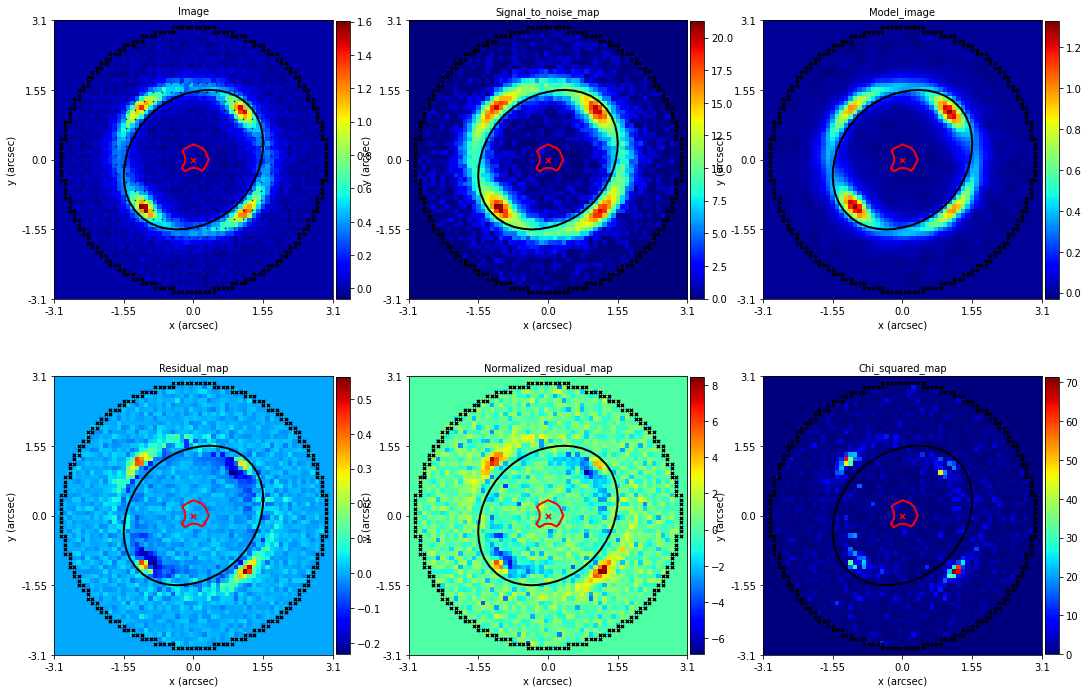

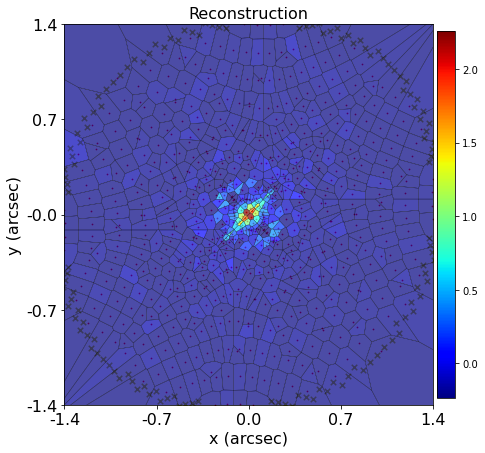

In [8]:
source_magnification = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.VoronoiMagnification(shape=(30, 30)),
    regularization=al.reg.Constant(coefficient=3.3),
)

fit = fit_masked_imaging_with_source_galaxy(
    masked_imaging=masked_imaging, source_galaxy=source_magnification
)

aplt.FitImaging.subplot_fit_imaging(
    fit=fit, include=aplt.Include(inversion_image_pixelization_grid=True, mask=True)
)

aplt.Inversion.reconstruction(
    inversion=fit.inversion, include=aplt.Include(inversion_pixelization_grid=True)
)

The fit isn't great. The main structure of the lensed source is reconstructed, but there are residuals. These 
residuals are worse than we saw in the previous tutorials (when source's compact central structure was the problem). 
So, the obvious question is can our adaptive _Pixelization_ and _Regularization_schemes address the problem?

Lets find out, using this solution as our hyper-galaxy-image. In this case, our hyper-galaxy-image isn't a perfect 
fit to the data. This shouldn't be too problematic, as the solution still captures the source's overall structure. 
The _Pixelization_ / _Regularization_hyper-galaxy-parameters have enough flexibility in how they use this image to 
adapt themselves, so the hyper-galaxy-image doesn't *need* to be perfect.

In [9]:
hyper_image = fit.model_image.in_1d_binned

You'll note that, unlike before, this source galaxy receives two types of hyper-galaxy-images, a 'hyper_galaxy_image' 
(like before) and a 'hyper_model_image' (which is new). I'll come back to this later.

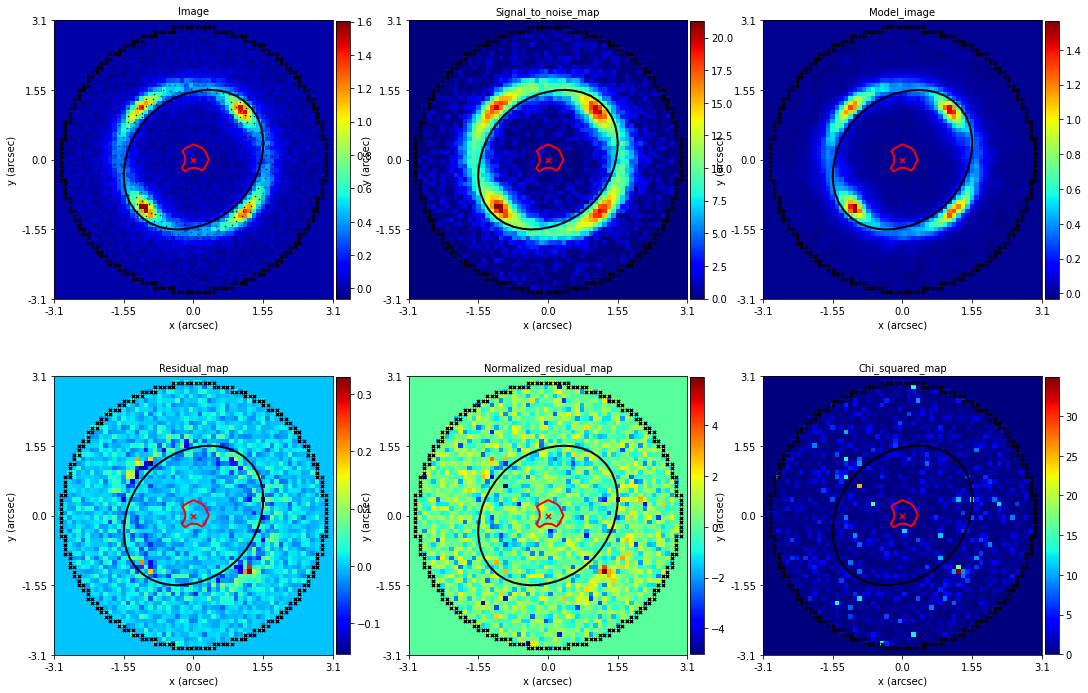

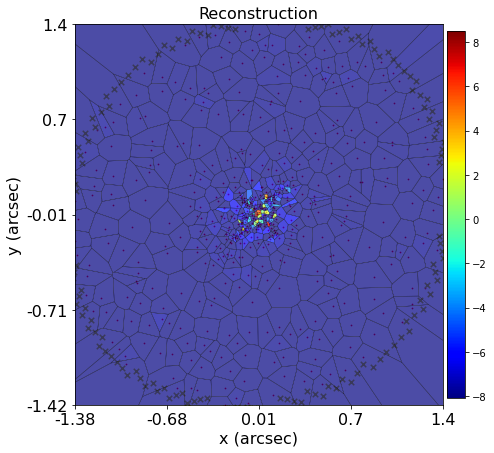

Evidence =  4023.694404148393


In [10]:
source_adaptive = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.VoronoiBrightnessImage(
        pixels=500, weight_floor=0.0, weight_power=5.0
    ),
    regularization=al.reg.AdaptiveBrightness(
        inner_coefficient=0.001, outer_coefficient=0.2, signal_scale=2.0
    ),
    hyper_galaxy_image=hyper_image,
    hyper_model_image=hyper_image,
)

fit = fit_masked_imaging_with_source_galaxy(
    masked_imaging=masked_imaging, source_galaxy=source_adaptive
)

aplt.FitImaging.subplot_fit_imaging(
    fit=fit, include=aplt.Include(inversion_image_pixelization_grid=True, mask=True)
)

aplt.Inversion.reconstruction(
    inversion=fit.inversion, include=aplt.Include(inversion_pixelization_grid=True)
)

print("Evidence = ", fit.log_evidence)

The solution is better, but far from perfect. Furthermore, this solution maximizes the Bayesian log evidence, meaning 
there is no reasonable way to change our source _Pixelization_ or _Regularization_to better fit the data. The problem 
is with our lens's mass model!

This poses a major problem for our model-fitting. A small subset of our data has such large chi-squared values the 
non-linear search is going to seek solutions which reduce only these chi-squared values. For the image above, a 
small subset of our data (e.g. < 5% of pixels) contributes to the majority of our log_likelihood (e.g. > 95% of the 
overall chi-squared). This is *not* what we want, as it means that instead of using the entire surface brightness 
profile of the lensed source galaxy to constrain our lens model, we end up using only a small subset of its brightest 
pixels.

This is even more problematic when we try and use the Bayesian log evidence to objectively quantify the quality of the 
fit, as it means it cannot obtain a solution that provides a reduced chi-squared of 1.

So, you're probably wondering, why can't we just change the mass model to fit the data better? Surely if we 
actually modeled this image with PyAutoLens it wouldn't go to this solution anyway but instead infer the correct 
Einstein radius of 1.6? That's true.

However, for *real* strong gravitational lenses, there is no such thing as a 'correct mass model'. Real galaxies are 
not _EllipticalIsothermal profiles_, or power-laws, or NFW's, or any of the symmetric and smooth analytic profiles we 
assume to model their mass. For real strong lenses our mass model will pretty much always lead to source-reconstruction 
residuals, producing these skewed chi-squared distributions. PyAutoLens can't remove them by simply improving the 
mass model.

This is where noise-map scaling comes in. If we have no alternative, the best way to get Gaussian-distribution 
(e.g. more uniform) chi-squared fit is to increase the variances of image pixels with high chi-squared values. So, 
that's what we're going to do, by making our source galaxy a 'hyper-galaxy', a galaxy which use's its hyper-galaxy 
image to increase the noise in pixels where it has a large signal. Let take a look.

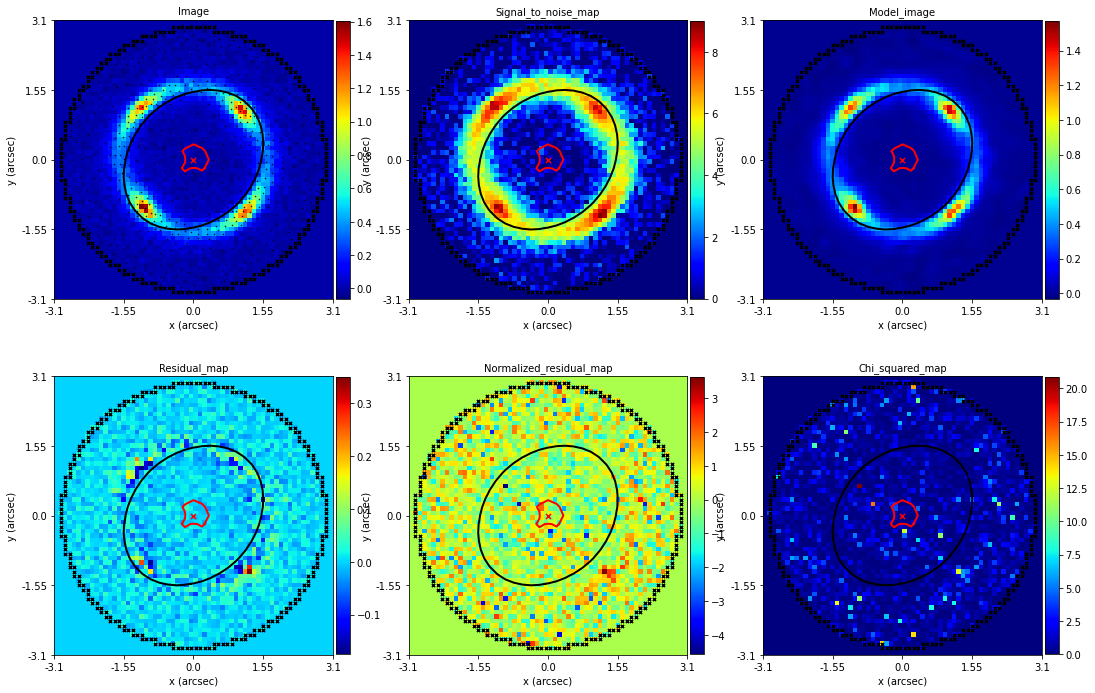

In [11]:
source_hyper_galaxy = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.VoronoiBrightnessImage(
        pixels=500, weight_floor=0.0, weight_power=5.0
    ),
    regularization=al.reg.AdaptiveBrightness(
        inner_coefficient=0.001, outer_coefficient=0.2, signal_scale=2.0
    ),
    hyper_galaxy=al.HyperGalaxy(
        contribution_factor=1.0, noise_factor=1.5, noise_power=1.0
    ),
    hyper_galaxy_image=hyper_image,
    hyper_model_image=hyper_image,
    binned_hyper_galaxy_image=hyper_image,
)

fit = fit_masked_imaging_with_source_galaxy(
    masked_imaging=masked_imaging, source_galaxy=source_hyper_galaxy
)

aplt.FitImaging.subplot_fit_imaging(
    fit=fit, include=aplt.Include(inversion_image_pixelization_grid=True, mask=True)
)

As expected, the chi-squared distribution looks *alot* better. The chi-squareds have reduced from the 200's to the 
50's, because the variances were increased. This is what we want, so lets make sure we see an appropriate increase in 
Bayesian log evidence

In [12]:
print("Evidence using baseline variances = ", 8911.66)

print("Evidence using variances scaling by hyper-galaxy = ", fit.log_evidence)

Evidence using baseline variances =  8911.66
Evidence using variances scaling by hyper-galaxy =  4090.153362909056


Yep, a huge increase in the 1000's! Clearly, if our model doesn't fit the data well we *need* to increase the noise 
wherever the fit is poor to ensure that our use of the Bayesian log evidence is well defined.

__How does the HyperGalaxy that we attached to the source-galaxy above actually scale the noise?__

First, it creates a 'contribution_map' from the hyper-galaxy-image of the lensed source galaxy. This uses the 
'hyper_model_image', which is the overall model-image of the best-fit lens model. In this tutorial, because our 
strong lens _Imaging_ only has a source galaxy emitting light, the hyper-galaxy-image of the source galaxy is the same 
as the hyper_model_image. However, In the next tutorial, we'll introduce the lens galaxy's light, such that each 
hyper-galaxy image is different to the hyper-galaxy model image!

We compute the contribution map as follows:

    1) Add the 'contribution_factor' hyper-galaxy-parameter value to the 'hyper_model_image'.
    
    2) Divide the 'hyper_galaxy_image' by the hyper-galaxy-model image created in step 1).
    
    3) Divide the image created in step 2) by its maximum value, such that all pixels range between 0.0 and 1.0.

Lets look at a few contribution maps, generated using hyper-_Galaxy_'s with different contribution factors.

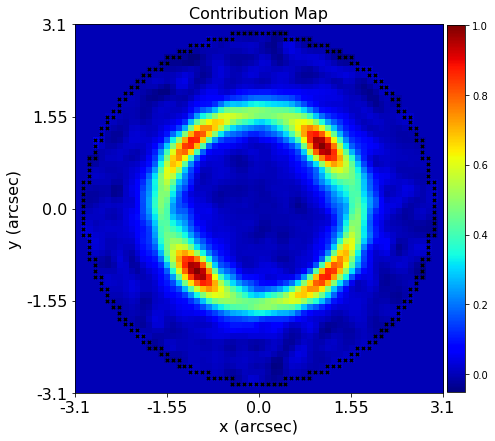

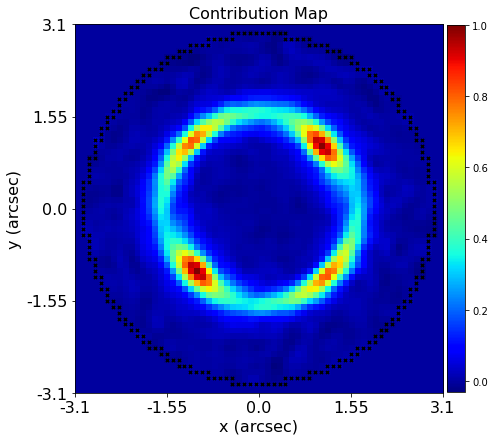

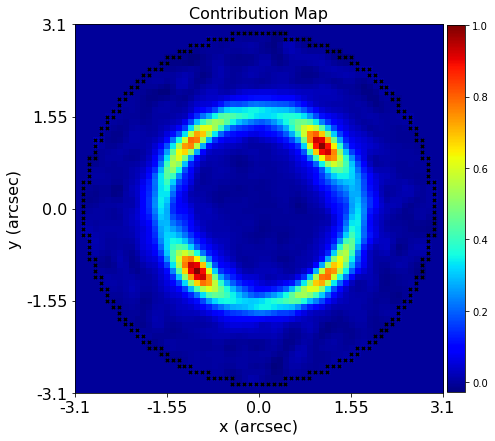

In [13]:
source_contribution_factor_1 = al.Galaxy(
    redshift=1.0,
    hyper_galaxy=al.HyperGalaxy(contribution_factor=1.0),
    hyper_galaxy_image=hyper_image,
    hyper_model_image=hyper_image,
    binned_hyper_galaxy_image=hyper_image,
)

contribution_map = source_contribution_factor_1.hyper_galaxy.contribution_map_from_hyper_images(
    hyper_model_image=hyper_image, hyper_galaxy_image=hyper_image
)

aplt.Array(
    array=contribution_map,
    mask=mask,
    plotter=aplt.Plotter(labels=aplt.Labels(title="Contribution Map")),
)

source_contribution_factor_3 = al.Galaxy(
    redshift=1.0,
    hyper_galaxy=al.HyperGalaxy(contribution_factor=3.0),
    hyper_galaxy_image=hyper_image,
    hyper_model_image=hyper_image,
    binned_hyper_galaxy_image=hyper_image,
)

contribution_map = source_contribution_factor_3.hyper_galaxy.contribution_map_from_hyper_images(
    hyper_model_image=hyper_image, hyper_galaxy_image=hyper_image
)

aplt.Array(
    array=contribution_map,
    mask=mask,
    plotter=aplt.Plotter(labels=aplt.Labels(title="Contribution Map")),
)

source_hyper_galaxy = al.Galaxy(
    redshift=1.0,
    hyper_galaxy=al.HyperGalaxy(contribution_factor=5.0),
    hyper_galaxy_image=hyper_image,
    hyper_model_image=hyper_image,
    binned_hyper_galaxy_image=hyper_image,
)

contribution_map = source_hyper_galaxy.hyper_galaxy.contribution_map_from_hyper_images(
    hyper_model_image=hyper_image, hyper_galaxy_image=hyper_image
)

aplt.Array(
    array=contribution_map,
    mask=mask,
    plotter=aplt.Plotter(labels=aplt.Labels(title="Contribution Map")),
)

By increasing the contribution factor we allocate more pixels with higher contributions (e.g. values closer to 1.0) 
than pixels with lower values. This is all the contribution_factor does; it scales how we allocate contributions to 
the source galaxy. Now, we're going to use this contribution map to scale the noise-map, as follows:

    1) Multiply the baseline (e.g. unscaled) noise-map of the image-data by the contribution map made in step 3) above. 
      This means that only noise-map values where the contribution map has large values (e.g. near 1.0) are going to 
      remain in this image, with the majority of values multiplied by contribution map values near 0.0.
    
    2) Raise the noise-map generated in step 1) above to the power of the hyper-galaxy-parameter noise_power. Thus, for 
       large values of noise_power, the largest noise-map values will be increased even more, raising their noise the 
       most.
    
    3) Multiply the noise-map values generated in step 2) by the hyper-galaxy-parameter noise_factor. Again, this is a
       means by which PyAutoLens is able to scale the noise-map values.

Lets compare two fits, one where a hyper-galaxy scales the noise-map, and one where it doesn't.

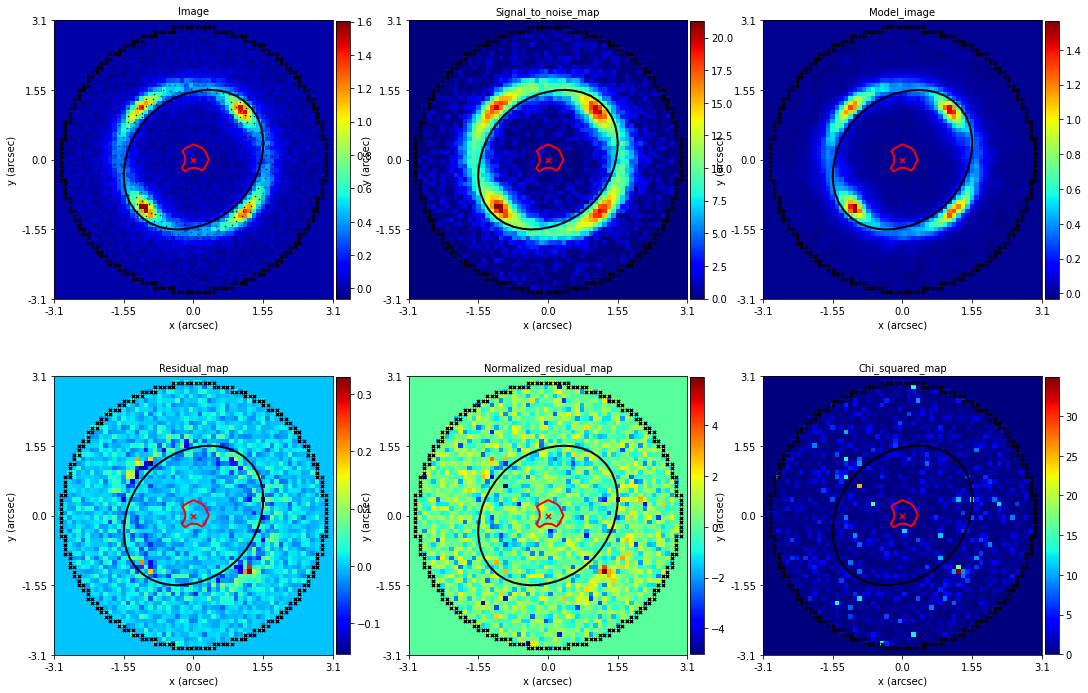

Evidence using baseline variances =  4023.694404148393


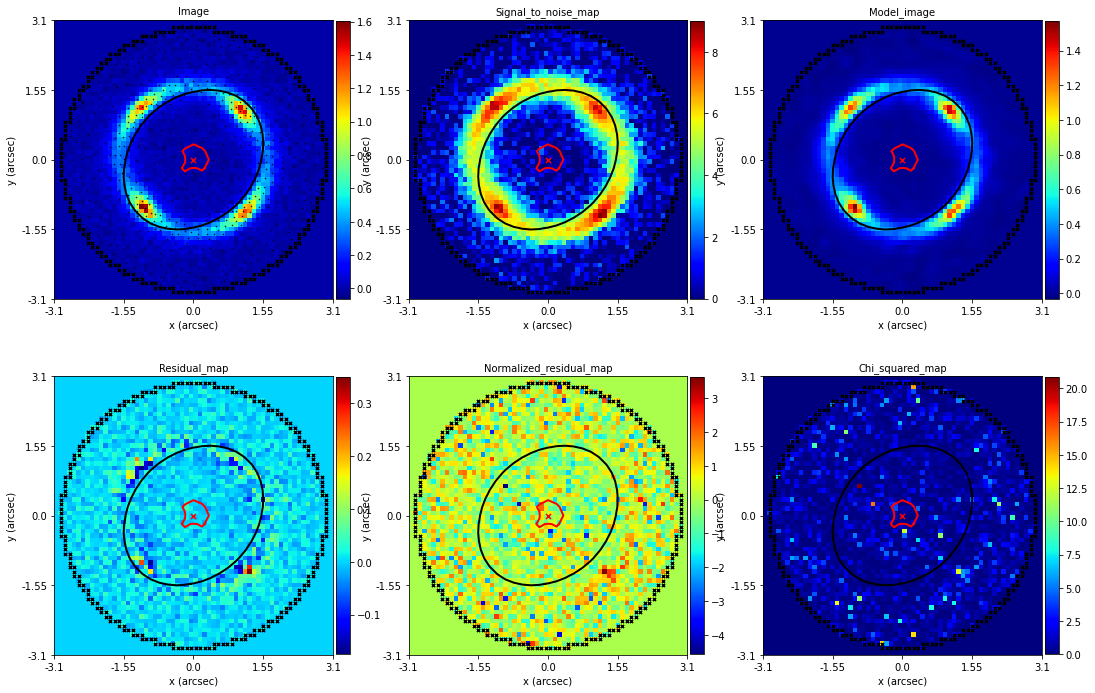

Evidence using variances scaling by hyper-galaxy =  4090.153362909056


In [14]:
source_no_hyper_galaxy = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.VoronoiBrightnessImage(
        pixels=500, weight_floor=0.0, weight_power=5.0
    ),
    regularization=al.reg.AdaptiveBrightness(
        inner_coefficient=0.001, outer_coefficient=0.2, signal_scale=2.0
    ),
    hyper_galaxy_image=hyper_image,
    binned_hyper_galaxy_image=hyper_image,
)

fit = fit_masked_imaging_with_source_galaxy(
    masked_imaging=masked_imaging, source_galaxy=source_no_hyper_galaxy
)

aplt.FitImaging.subplot_fit_imaging(
    fit=fit, include=aplt.Include(inversion_image_pixelization_grid=True, mask=True)
)


print("Evidence using baseline variances = ", fit.log_evidence)

source_hyper_galaxy = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.VoronoiBrightnessImage(
        pixels=500, weight_floor=0.0, weight_power=5.0
    ),
    regularization=al.reg.AdaptiveBrightness(
        inner_coefficient=0.001, outer_coefficient=0.2, signal_scale=2.0
    ),
    hyper_galaxy=al.HyperGalaxy(
        contribution_factor=1.0, noise_factor=1.5, noise_power=1.0
    ),
    hyper_galaxy_image=hyper_image,
    hyper_model_image=hyper_image,
)

fit = fit_masked_imaging_with_source_galaxy(
    masked_imaging=masked_imaging, source_galaxy=source_hyper_galaxy
)

aplt.FitImaging.subplot_fit_imaging(
    fit=fit, include=aplt.Include(inversion_image_pixelization_grid=True, mask=True)
)


print("Evidence using variances scaling by hyper-galaxy = ", fit.log_evidence)

Feel free to play around with the noise_factor and noise_power hyper-galaxy-parameters above. It should be fairly 
clear what they do; they simply change the amount by which the noise is increased.

And with that, we've completed the first of two tutorials on noise-map scaling. To end, I want you to have a quick 
think, is there anything else that you can think of that would mean we need to scale the noise? In this tutorial, 
it was the inadequacy of our mass-model that lead to significant residuals and a skewed chi-squared distribution. 
What else might cause residuals? I'll give you a couple below;

    1) A mismatch between our model of the _Imaging_ data's Point Spread Function (PSF) and the true PSF of the 
       telescope optics of the data.
    
    2) Unaccounted for effects in our idata-reduction for the image, in particular the presense of correlated signal and 
       noise during the image's instrument reduction.
    
    3) A sub-optimal background sky subtraction of the image, which can leave large levels of signal in the outskirts of 
       the image that are not due to the strong lens system itself.

Oh, there's on more thing that can cause much worse residuals than all the effects above. That'll be the topic of 
the next tutorial.